
# Mettetal (2019): “Hydrodams in South Africa: Population Density Analysis”

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from rasterio.plot import show as rioshow
import matplotlib as mpl
import numpy as np
import matplotlib.patches as mpatches
from shapely import wkt
import os

# Set the base path to your folder
base_path = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/South Africa"

# Define file paths (using your updated population raster file name)
muni_shp = f"{base_path}/MDB_Local_Municipal_Boundary_2018.shp"
dams_excel = f"{base_path}/Dams_south_africa.xlsx"
pop_raster = f"{base_path}/zaf_general_2020.tif"

# Load the municipal boundaries shapefile
gdf_munis = gpd.read_file(muni_shp)
print("Municipalities CRS:", gdf_munis.crs)

# Load the dam locations from Excel
dams_df = pd.read_excel(dams_excel)
print("Dam Data Columns:", dams_df.columns)

Municipalities CRS: EPSG:4326
Dam Data Columns: Index(['Name of dam', 'Latitude deg', 'Lat min', 'Lat sec', 'Longitude deg',
       'Long min', 'Long sec'],
      dtype='object')


In [30]:

# Convert DMS to Decimal Degrees for dam locations.
# For South Africa, latitude should be negative.
dams_df["lat_dd"] = -(dams_df["Latitude deg"] + dams_df["Lat min"] / 60 + dams_df["Lat sec"] / 3600)
dams_df["lon_dd"] = dams_df["Longitude deg"] + dams_df["Long min"] / 60 + dams_df["Long sec"] / 3600

# (Optional) Check a few converted coordinates:
print(dams_df[["Name of dam", "lat_dd", "lon_dd"]].head())

# Create a GeoDataFrame for dam locations using the converted coordinates
gdf_dams = gpd.GeoDataFrame(
    dams_df,
    geometry=gpd.points_from_xy(dams_df["lon_dd"], dams_df["lat_dd"]),
    crs="EPSG:4326"  # Coordinates now in WGS84
)

         Name of dam     lat_dd     lon_dd
0       NGOTWANE DAM -25.198333  25.813333
1      MAKGOPANE DAM -25.098389  25.882500
2    ROODEKOPJES DAM -25.406667  27.577500
3  HARTBEESPOORT DAM -25.725639  27.848361
4   BUFFELSPOORT DAM -25.780417  27.487361


In [31]:
# Open the population raster and print its CRS
with rasterio.open(pop_raster) as src:
    raster_crs = src.crs
    print("Raster CRS:", raster_crs)

# Ensure municipal boundaries are in the same CRS as the raster
if gdf_munis.crs != raster_crs:
    gdf_munis = gdf_munis.to_crs(raster_crs)

# Compute zonal statistics (sum) for each municipality using the population raster
stats = zonal_stats(
    gdf_munis,
    pop_raster,
    stats=["sum"],
    geojson_out=True
)

# Convert the zonal statistics (a list of GeoJSON features) to a GeoDataFrame
gdf_stats = gpd.GeoDataFrame.from_features(stats)
gdf_stats.crs = gdf_munis.crs

# Add the total population computed from the raster to the municipal GeoDataFrame
gdf_munis["total_pop"] = gdf_stats["sum"]

Raster CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


In [32]:
# Reproject to a metric CRS (EPSG:3857 uses meters) for accurate area calculations
gdf_munis = gdf_munis.to_crs(epsg=3857)
gdf_munis["area_km2"] = gdf_munis.area / 1e6  # Convert area from m² to km²

# Calculate population density (people per km²)
gdf_munis["pop_density"] = gdf_munis["total_pop"] / gdf_munis["area_km2"]

In [35]:
gdf_plot = gdf_munis.to_crs(epsg=4326)
gdf_dams_plot = gdf_dams.to_crs(epsg=4326)

# Remove any dams that fall outside the municipal boundaries
# using a spatial join to keep only intersecting points
gdf_dams_plot = gpd.sjoin(
    gdf_dams_plot, gdf_plot[["geometry"]],
    how="inner", predicate="intersects"
)
gdf_dams_plot.drop(columns=["index_right"], inplace=True)


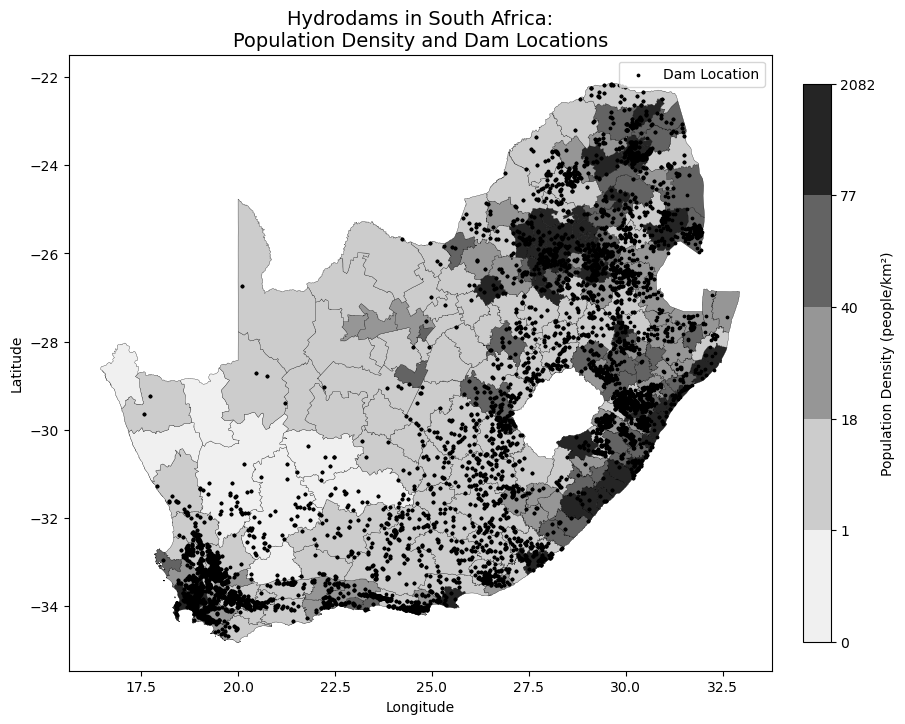

In [50]:
#    (Here, we use 5 colors from fairly light gray to black)
colors = [
    "#f0f0f0",  # very light gray (instead of pure white #ffffff)
    "#cccccc",
    "#969696",
    "#636363",
    "#252525"   # near black
]
my_cmap = mpl.colors.ListedColormap(colors)

bins = [0, 1, 18, 40, 77, 2082]

fig, ax = plt.subplots(figsize=(10, 8))

plot_obj = gdf_plot.plot(
    column="pop_density",
    scheme="UserDefined",
    classification_kwds={'bins': bins[1:]},
    cmap=my_cmap,            # Use our custom colormap
    edgecolor="black",
    linewidth=0.2,
    legend=False,
    ax=ax
)

norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=my_cmap.N)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=my_cmap)
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=ax,
    boundaries=bins,
    fraction=0.036,
    pad=0.04
)
cbar.set_label("Population Density (people/km²)")
cbar.set_ticks(bins)
cbar.set_ticklabels([str(b) for b in bins])

gdf_dams_plot.plot(
    ax=ax,
    marker="o",
    color="black",
    markersize=3,
    label="Dam Location"
)

ax.set_title("Hydrodams in South Africa:\nPopulation Density and Dam Locations", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc="upper right")

plt.show()

# Fried & Lagakos (2021): “Ethiopian Population Density and ERSS Villages”

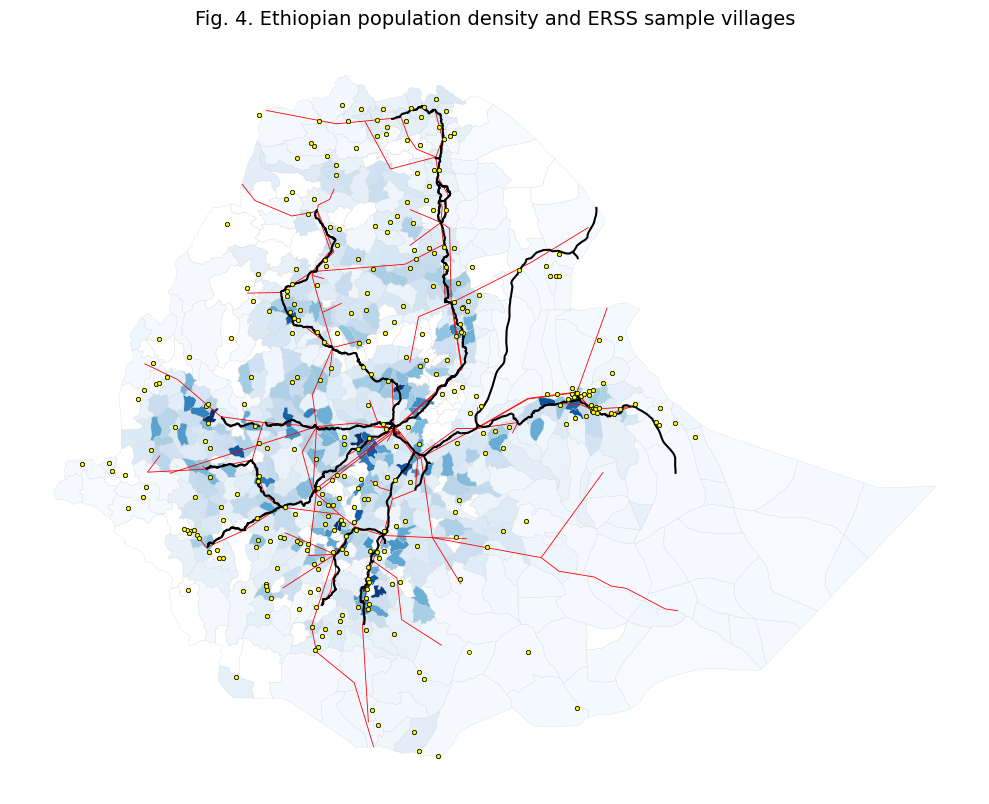

In [86]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# File Paths 
admin_shp     = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Ethiopia/Ethiopia_AdminBoundaries-shp/Ethiopia_AdminBoundaries.shp"
pop_csv       = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Ethiopia/eth_admpop_adm2_2022_v2.csv"
roads_shp     = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Ethiopia/ethiopia_roads/Ethiopia_Roads.shp"
grid_shp      = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Ethiopia/ethiopia-electricity-transmission-network/Ethiopia Electricity Transmission Network.shp"
household_csv = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Ethiopia/ETH_2011_ERSS_v02_M_CSV/pub_eth_householdgeovariables_y1.csv"

# Load Files
gdf_admin  = gpd.read_file(admin_shp)
df_cod     = pd.read_csv(pop_csv, dtype=str)
gdf_roads  = gpd.read_file(roads_shp)
gdf_grid   = gpd.read_file(grid_shp)
df_house   = pd.read_csv(household_csv)

# Build & clean join‐keys (keep all admin units) 
codes = gdf_admin['WOREDANO_'].astype(str).str.zfill(6)
gdf_admin['adm2_key'] = 'ET' + codes.str[:2] + codes.str[-2:]
df_pop['adm2_key']     = df_pop['admin2Pcode'].str.strip().str.upper()

# Merge population & compute density for all units
# Left‐merge so unmatched units get NaN
gdf_admin = gdf_admin.merge(
    df_pop[['adm2_key','T_TL']],
    on='adm2_key',
    how='left'
)
gdf_admin['pop_total'] = pd.to_numeric(gdf_admin['T_TL'], errors='coerce')

# Project to Web Mercator
gdf_admin_3857 = gdf_admin.to_crs("EPSG:3857")
gdf_admin_3857['area_km2'] = gdf_admin_3857.geometry.area / 1e6
gdf_admin_3857['density']  = gdf_admin_3857['pop_total'] / gdf_admin_3857['area_km2']

# Prepare roads, grid & villages 
gdf_roads_3857 = gdf_roads.to_crs("EPSG:3857")
gdf_grid_3857  = gdf_grid .to_crs("EPSG:3857")
gdf_house = gpd.GeoDataFrame(
    df_house,
    geometry=gpd.points_from_xy(df_house['LON_DD_MOD'], df_house['LAT_DD_MOD']),
    crs="EPSG:4326"
)
gdf_house_3857 = gdf_house.to_crs("EPSG:3857")

# Plotting
fig, ax = plt.subplots(figsize=(10, 12))
fig.patch.set_facecolor('white'); ax.set_facecolor('white')

vmax = gdf_admin_3857['density'].quantile(0.99)
gdf_admin_3857.plot(
    column='density',
    cmap='Blues',
    norm=Normalize(vmin=0, vmax=vmax),
    edgecolor='lightgray',
    linewidth=0.2,
    ax=ax,
    zorder=0,
    missing_kwds={
        'color': 'white',
        'edgecolor': 'lightgray'
    }
)

gdf_grid_3857.plot(
    ax=ax, linewidth=0.6, edgecolor='red', zorder=1
)
gdf_roads_3857.plot(
    ax=ax, linewidth=1.5, edgecolor='black', zorder=2
)
gdf_house_3857.plot(
    ax=ax,
    markersize=8,
    facecolor='yellow',
    edgecolor='black',
    linewidth=0.4,
    zorder=3
)

ax.set_axis_off()
ax.set_title(
    "Fig. 4. Ethiopian population density and ERSS sample villages",
    fontsize=14,
    pad=12
)
plt.tight_layout()
plt.show()


# Balboni (2025): “Roadmap of Vietnam: Infrastructure & Road Types”

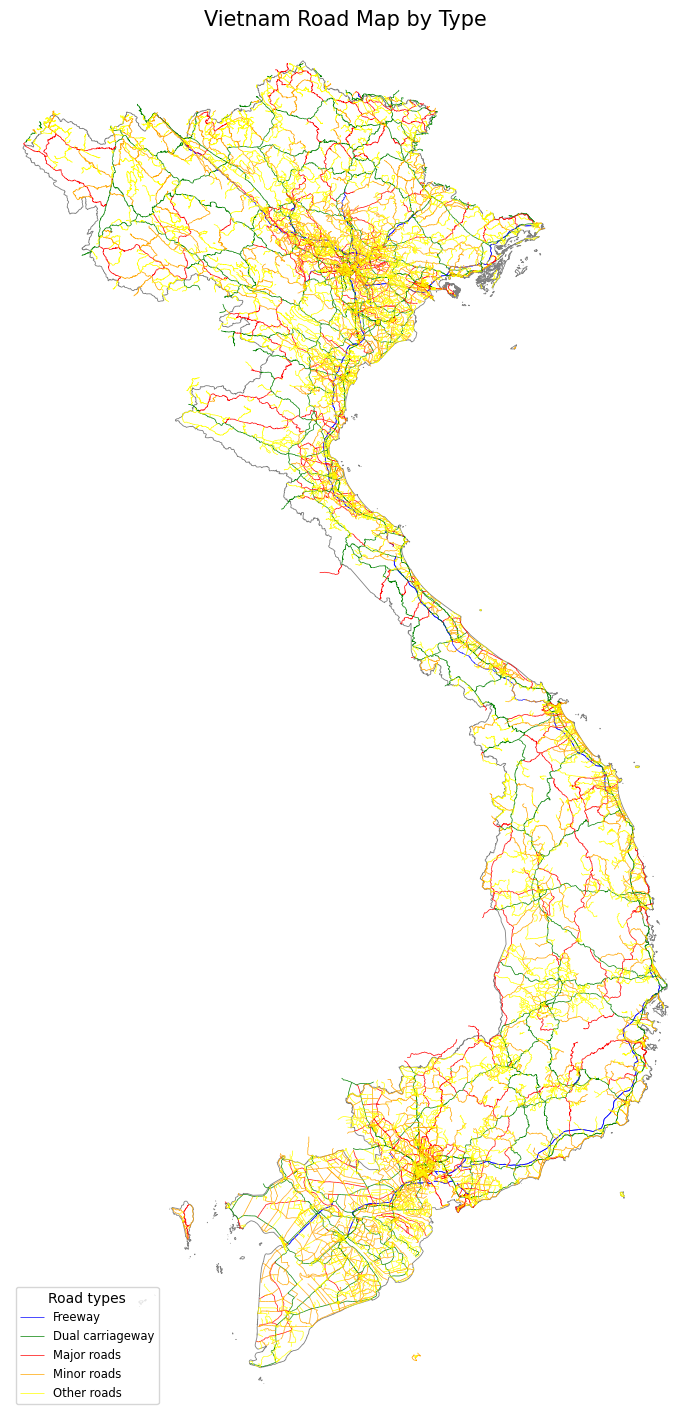

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# File Paths
roads_fp    = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Vietnam/vietnam-latest-free.shp/gis_osm_roads_free_1.shp"
boundary_fp = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Vietnam/gadm41_VNM_shp/gadm41_VNM_0.shp"

# Load Data 
gdf_roads     = gpd.read_file(roads_fp)
gdf_boundary  = gpd.read_file(boundary_fp)

# Define Road Type → Label → Color Mapping
road_map = {
    "motorway":  ("Freeway",          "blue"),
    "trunk":     ("Dual carriageway", "green"),
    "primary":   ("Major roads",      "red"),
    "secondary": ("Minor roads",      "orange"),
    "tertiary":  ("Other roads",      "yellow")
}

# Plot
fig, ax = plt.subplots(figsize=(10, 14))

# Boundary
gdf_boundary.plot(ax=ax, color='white', edgecolor='gray', linewidth=0.6)

# Roads by type
for fclass, (label, color) in road_map.items():
    subset = gdf_roads[gdf_roads['fclass'] == fclass]
    if not subset.empty:
        subset.plot(ax=ax, color=color, linewidth=0.5, label=label)

# get Vietnam’s bounds
minx, miny, maxx, maxy = gdf_boundary.total_bounds

# small 2% padding
pad_x = (maxx - minx) * 0.02
pad_y = (maxy - miny) * 0.02

ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

# force equal aspect and no extra margins
ax.set_aspect('equal', adjustable='box')
ax.margins(0)

# Final Touches
ax.set_title("Vietnam Road Map by Type", fontsize=15)
ax.axis('off')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Road types", loc='lower left', fontsize='small')

plt.tight_layout(pad=0)
plt.show()

# Morten & Oliveira (2024): “Brazil’s Capital and Main Road Infrastructure”

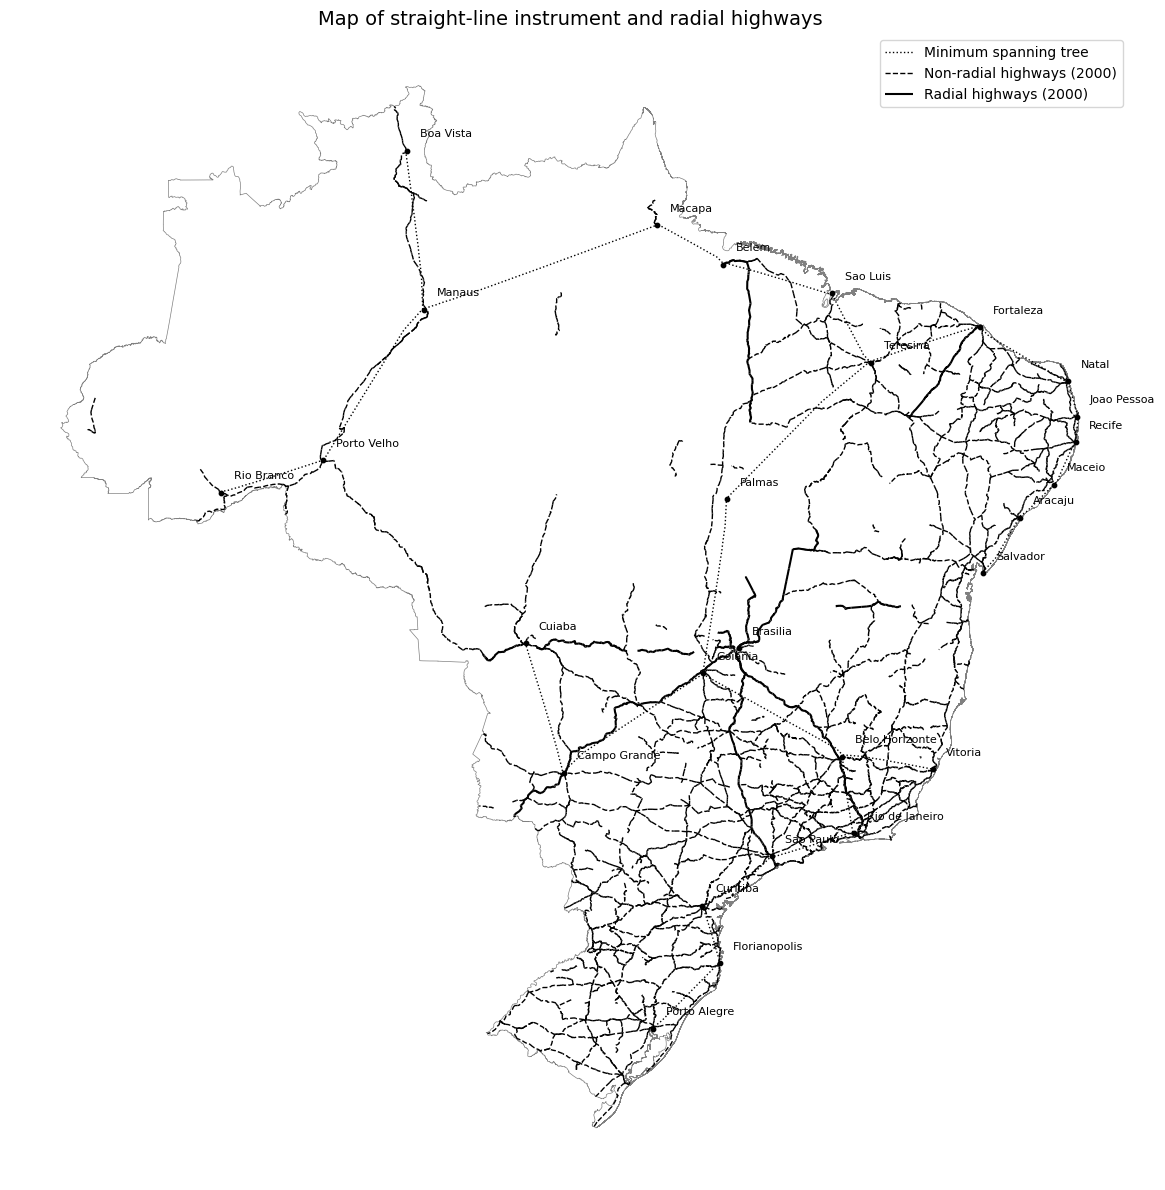

In [91]:
import geopandas as gpd
import matplotlib.pyplot as plt

# File Paths
outline_path = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Brazil/Data/GIS_data/outline/outline_mainland_only_prj.shp"
cities_path = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Brazil/Data/GIS_data/cities/brazil_capital_cities_prj.shp"
roads_path = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Brazil/Data/GIS_data/roads/2000/highways_2000_prj.shp"
mst_path = "/Users/mkristinetayag/Desktop/Subjectes/Second Sem/Econ 138/Brazil/Data/GIS_data/mst/mst_all_rio_prj.shp"

# Load Data
gdf_outline = gpd.read_file(outline_path)
gdf_cities = gpd.read_file(cities_path)
gdf_roads = gpd.read_file(roads_path)
gdf_mst = gpd.read_file(mst_path)

# Filter Roads 
gdf_radial = gdf_roads[gdf_roads["dm_radial"] == 1]
gdf_non_radial = gdf_roads[gdf_roads["dm_radial"] == 0]

# Plot Map 
fig, ax = plt.subplots(figsize=(12, 12))

# Brazil outline
gdf_outline.plot(ax=ax, color="white", edgecolor="gray", linewidth=0.5)

# Minimum Spanning Tree: dotted line
gdf_mst.plot(ax=ax, color="black", linestyle=":", linewidth=1, label="Minimum spanning tree")

# Highways
gdf_non_radial.plot(ax=ax, color="black", linestyle="--", linewidth=1, label="Non-radial highways (2000)")
gdf_radial.plot(ax=ax, color="black", linestyle="-", linewidth=1.5, label="Radial highways (2000)")

# Cities
gdf_cities.plot(ax=ax, color="black", markersize=10)

# City labels
for idx, row in gdf_cities.iterrows():
    ax.text(row.geometry.x + 0.5, row.geometry.y + 0.5, row["CITY_NAME"], fontsize=8)

# Style
ax.set_title("Map of straight-line instrument and radial highways", fontsize=14)
ax.axis("off")
ax.legend()

plt.tight_layout()
plt.show()